# Coursera class Python and Statistics for Financial Analysis


In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import math
from pandas_datareader import data 
import datetime
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

In [2]:
# Our input Variables

tickers = ['FB','MSFT']

# Date Ranges for for all tickers

# The below will pull back stock prices from 2010 until end date specified.
start_sp = datetime.datetime(2010, 1, 1)
end_sp = datetime.datetime(2020, 3, 31)

In [3]:
# This variable is used for YTD performance.
end_of_last_year = datetime.datetime(2019, 12, 30)

# These are separate if for some reason want different date range than SP.
stocks_start = datetime.datetime(2013, 1, 1)
stocks_end = datetime.datetime(2020, 3, 31)


tickers = [x.upper() for x in tickers] 
n_assets = len(tickers) 

stockBucket = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stockBucket[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=stocks_start, end=stocks_end)["Adj Close"] 

stockBucket.head()

,FB,MSFT
Date,,
2013-01-02,28.000000,23.297653
2013-01-03,27.770000,22.985548
2013-01-04,28.760000,22.555361
2013-01-07,29.420000,22.513191
2013-01-08,29.059999,22.395096


In [4]:
# function to extract specific symbol
def getSpecificStockFromBucket(bucketName, stockSymbol):
    return pd.DataFrame({'Adj Close':bucketName[stockSymbol].values}, index=bucketName[stockSymbol].index)

In [5]:
# extract specific symbol from our list
stocks = getSpecificStockFromBucket(stockBucket, "MSFT")
stocks.head()

,Adj Close
Date,
2013-01-02,23.297653
2013-01-03,22.985548
2013-01-04,22.555361
2013-01-07,22.513191
2013-01-08,22.395096


In [6]:
# check the column types in the dataframe
stocks.dtypes

Adj Close    float64
dtype: object

## Create a new column in the DataFrame (1) - Price difference

In [7]:
#Create a new column PriceDiff in the DataFrame fb
stocks['PriceDiff'] = stocks['Adj Close'].shift(-1) - stocks['Adj Close']
stocks.head()

#Run this code to display the price difference on a specific date
#print(stocks['PriceDiff'].loc['2015-01-05'])

,Adj Close,PriceDiff
Date,,
2013-01-02,23.297653,-0.312105
2013-01-03,22.985548,-0.430187
2013-01-04,22.555361,-0.042170
2013-01-07,22.513191,-0.118095
2013-01-08,22.395096,0.126528


In [8]:
# Daily Return is calcuated as PriceDiff/Close
#Create a new column Return in the DataFrame
stocks['Return'] = stocks['PriceDiff'] /stocks['Adj Close']
stocks.head()

,Adj Close,PriceDiff,Return
Date,,,
2013-01-02,23.297653,-0.312105,-0.013396
2013-01-03,22.985548,-0.430187,-0.018716
2013-01-04,22.555361,-0.042170,-0.001870
2013-01-07,22.513191,-0.118095,-0.005246
2013-01-08,22.395096,0.126528,0.005650


### Create a new column in the DataFrame using List Comprehension - Direction

In [9]:
#Create a new column Direction. 
#The List Comprehension means : if the price difference is larger than 0, denote as 1, otherwise, denote as 0,
#for every record in the DataFrame - fb

stocks['Direction'] = [1 if stocks['PriceDiff'].loc[ei] > 0 else 0 for ei in stocks.index ]
stocks.head()

,Adj Close,PriceDiff,Return,Direction
Date,,,,
2013-01-02,23.297653,-0.312105,-0.013396,0
2013-01-03,22.985548,-0.430187,-0.018716,0
2013-01-04,22.555361,-0.042170,-0.001870,0
2013-01-07,22.513191,-0.118095,-0.005246,0
2013-01-08,22.395096,0.126528,0.005650,1


### Create a new column in the DataFrame using Rolling Window calculation (.rolling()) - Moving average

In [10]:
stocks['ma50'] = stocks['Adj Close'].rolling(50).mean()
stocks.dropna()

,Adj Close,PriceDiff,Return,Direction,ma50
Date,,,,,
2013-03-14,23.932791,-0.085043,-0.003553,0,23.331839
2013-03-15,23.847748,0.051025,0.002140,1,23.342841
2013-03-18,23.898773,0.068039,0.002847,1,23.361105
2013-03-19,23.966812,0.119070,0.004968,1,23.389334
2013-03-20,24.085882,-0.178604,-0.007415,0,23.420788
...,...,...,...,...,...
2020-03-24,147.928009,-1.416061,-0.009573,0,165.418823
2020-03-25,146.511948,9.164490,0.062551,1,165.101402
2020-03-26,155.676437,-6.392212,-0.041061,0,164.990145


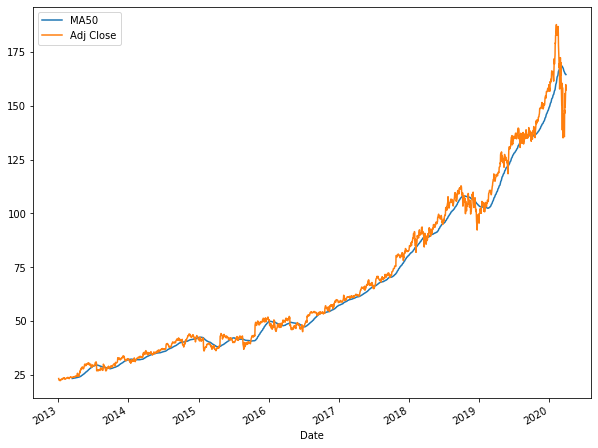

In [11]:
plt.figure(figsize=(10, 8))
stocks['ma50'].plot(label='MA50')
stocks['Adj Close'].plot(label='Adj Close')
plt.legend()
plt.show()

### Distribution of Log return

In [12]:
# let calculating the log daily return
stocks['LogReturn'] = np.log(stocks['Adj Close']).shift(-1) - np.log(stocks['Adj Close'])

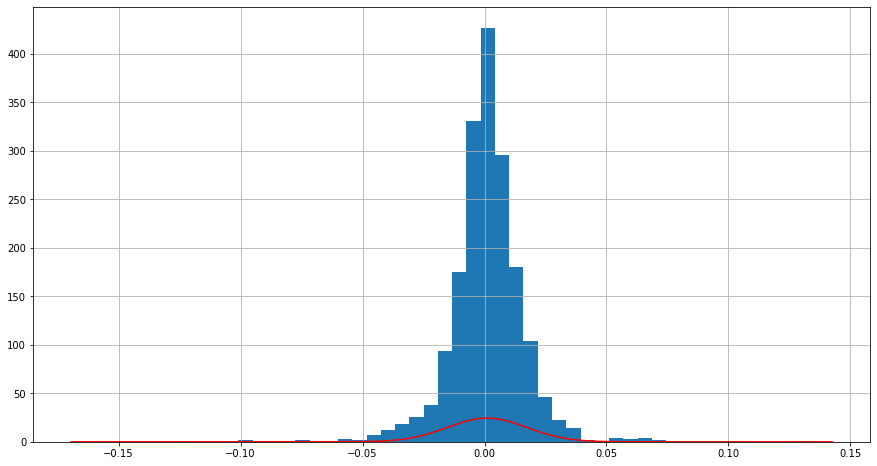

In [13]:
# Plot a histogram to show the distribution of log return  
# You can see it is very close to a normal distribution
from scipy.stats import norm
mu = stocks['LogReturn'].mean()
sigma = stocks['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(stocks['LogReturn'].min()-0.01, stocks['LogReturn'].max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

stocks['LogReturn'].hist(bins=50, figsize=(15, 8))
plt.plot(density['x'], density['pdf'], color='red')
plt.show()

### Calculate the probability of the stock price will drop over a certain percentage in a day

In [14]:
# probability that the stock price  will drop over 5% in a day
dropPercent = 5
prob_return1 = norm.cdf(-dropPercent/100, mu, sigma)
print('The Probability is ', prob_return1)

The Probability is  0.0008872418726979366


### Calculate the probability of the stock price will drop over a certain percentage in a year

In [15]:
# drop over 40% in 220 days
mu220 = 220*mu
sigma220 = (220**0.5) * sigma
print('The probability of dropping over 40% in 220 days is ', norm.cdf(-0.4, mu220, sigma220))

The probability of dropping over 40% in 220 days is  0.004626639795744997


### Calculate Value at risk (VaR)

In [16]:
# Value at risk(VaR)
VaR = norm.ppf(0.05, mu, sigma)
print('Single day value at risk ', VaR)

Single day value at risk  -0.02581642732941682


In [17]:
# Quatile 
# 5% quantile
print('5% quantile ', norm.ppf(0.05, mu, sigma))
# 95% quantile
print('95% quantile ', norm.ppf(0.95, mu, sigma))

5% quantile  -0.02581642732941682
95% quantile  0.027911461974694587


### Estimate the average stock return with 90% Confidence Interval

In [20]:
# using the log return computed earlier

# Lets build 90% confidence interval for log return
sample_size = stocks['LogReturn'].shape[0]
sample_mean = stocks['LogReturn'].mean()
sample_std = stocks['LogReturn'].std(ddof=1) / sample_size**0.5

# left and right quantile
z_left = norm.ppf(0.05)
z_right = norm.ppf(0.95)

# upper and lower bound
interval_left = sample_mean+z_left*sample_std
interval_right = sample_mean+z_right*sample_std

# 90% confidence interval tells you that there will be 90% chance that the average stock return lies between "interval_left"
# and "interval_right".

print('90% confidence interval is ', (interval_left, interval_right))

90% confidence interval is  (0.0004185075875331078, 0.001676527057744673)


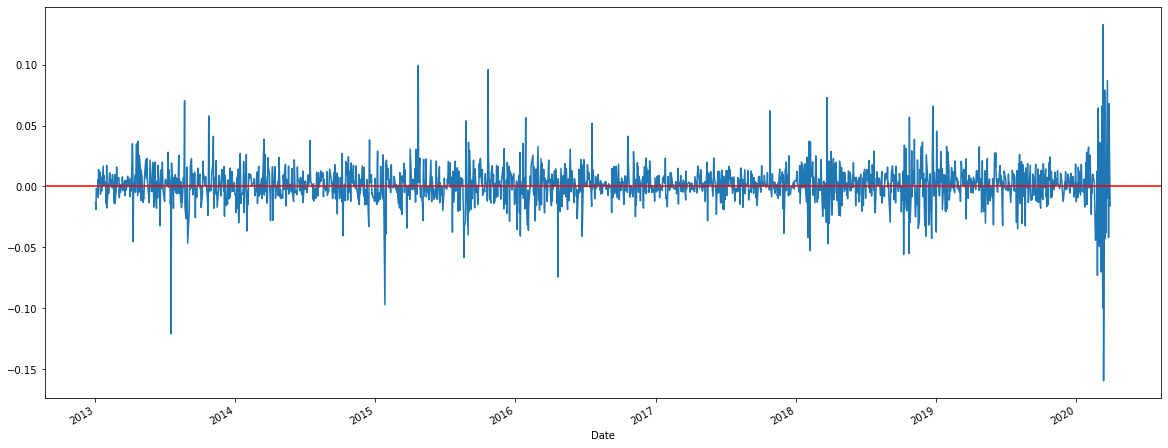

In [21]:
# plotting the log rturn
# Log return goes up and down during the period
stocks['LogReturn'].plot(figsize=(20, 8))
plt.axhline(0, color='red')
plt.show()

### Steps involved in testing a claim by hypothesis testing

Step 1: Set hypothesis

$H_0 : \mu = 0$

$H_a : \mu \neq 0$

H0 means the average stock return is 0

H1 means the average stock return is not equal to 0

Step 2: Calculate test statistic

In [22]:
sample_mean = stocks['LogReturn'].mean()
sample_std = stocks['LogReturn'].std(ddof=1)
n = stocks['LogReturn'].shape[0]

# if sample size n is large enough, we can use z-distribution, instead of t-distribtuion
# mu = 0 under the null hypothesis
zhat = (sample_mean - 0)/(sample_std/n**0.5)
print(zhat)

2.739246423820945


Step 3: Set decision criteria

In [23]:
# confidence level
alpha = 0.05

zleft = norm.ppf(alpha/2, 0, 1)
zright = -zleft  # z-distribution is symmetric 
print(zleft, zright)

-1.9599639845400545 1.9599639845400545


Step 4: Make decision - shall we reject H0?

In [24]:
print('At significant level of {}, we shall reject: {}'.format(alpha, zhat>zright or zhat<zleft))

At significant level of 0.05, we shall reject: True


An alternative method: p-value

 the correct calculation of p-value is explained here in detail.
 

If Ha: mu not equal 0, it is two tail test and p-value=2(1-norm.cdf(np.abs(z), 0, 1))

if Ha: mu>0, it is upper tail test and p-value=1-norm.cdf(z,0,1)

if Ha:mu<0, it is lower tail test and p-value=norm.cdf(z,0,1)

In [25]:
# step 3 (p-value)
p = 1 - norm.cdf(zhat, 0, 1)
print(p)

0.0030790098986240855


In [26]:
# step 4
print('At significant level of {}, we shall reject: {}'.format(alpha, p < alpha))

At significant level of 0.05, we shall reject: True
